In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob
from collections import OrderedDict

from dask.distributed import Client

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42985,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:39681,Total threads: 1
Dashboard: /proxy/34589/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41461,


In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_era5'
session = cc.database.create_session(db)

In [4]:
exptdict = OrderedDict([
#    ('1 JRA55 RYF',  {'expt':'1deg_jra55_ryf','cy':1,'color':'C0'}),
#    ('1 ERA5 RYF',  {'expt':'1deg_era5_ryf','cy':1,'color':'C1'}),
    ('1 JRA55 IAF',  {'expt':'1deg_jra55_iaf','cy':1,'color':'C2'}),
    ('1 ERA5 IAF',  {'expt':'1deg_era5_iaf','cy':1,'color':'C3'}),
    ('1 JRA55 IAF 1980+',  {'expt':'1deg_jra55_iaf_1980p','cy':1,'color':'C4'}),
    ('1 ERA5 IAF 1980+',  {'expt':'1deg_era5_iaf_1980p','cy':1,'color':'C5'})
])

## Check the final date for each expt.

In [6]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = var.time.isel(time=0)
    end_year = var.time.isel(time=-1)
    print(expt, start_year.values, end_year.values)

1deg_jra55_iaf 1959-01-02T00:00:00.000000000 2020-01-01T00:00:00.000000000
1deg_era5_iaf 1960-01-02T00:00:00.000000000 1979-01-01T00:00:00.000000000
1deg_jra55_iaf_1980p 1980-01-02T00:00:00.000000000 2020-01-01T00:00:00.000000000
1deg_era5_iaf_1980p 1980-01-02T00:00:00.000000000 2019-01-01T00:00:00.000000000


## Scalar diagnostics

In [7]:
def plot_timeseries(variable,keys=exptdict.keys(),ncfile=None):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session,ncfile=ncfile)
        if (exptdict[ekey]['cy'] == 1):
            var.plot(label=ekey,color=exptdict[ekey]['color'])
        else:
            var.plot(color=exptdict[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.legend()
    return

2023-03-29 10:01:02,659 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-03-29 10:01:07,800 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-03-29 10:01:09,912 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-03-29 10:01:10,882 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-03-29 10:01:11,927 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-03-29 10:01:12,777 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-03-29 10:01:14,054 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-03-29 10:01:15,058 - distributed.utils_perf - WARNING - full garbage collections took

Text(0.5, 1.0, 'Total KE')

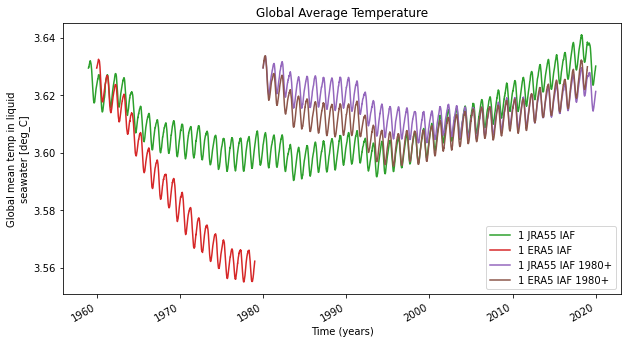

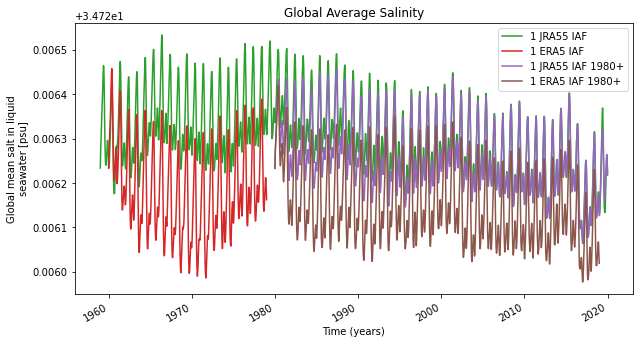

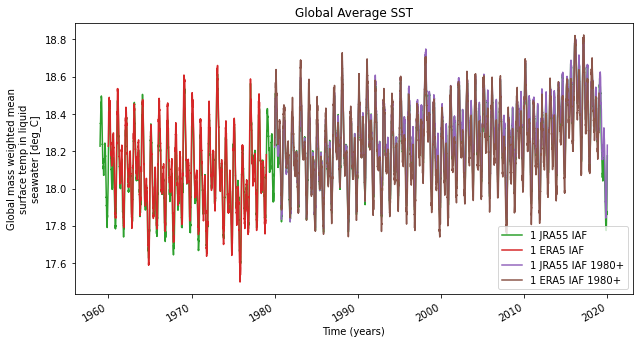

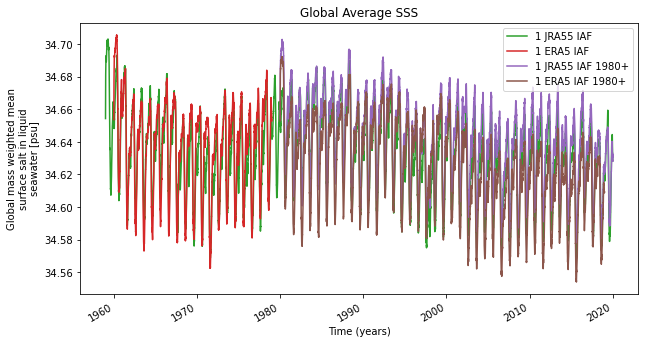

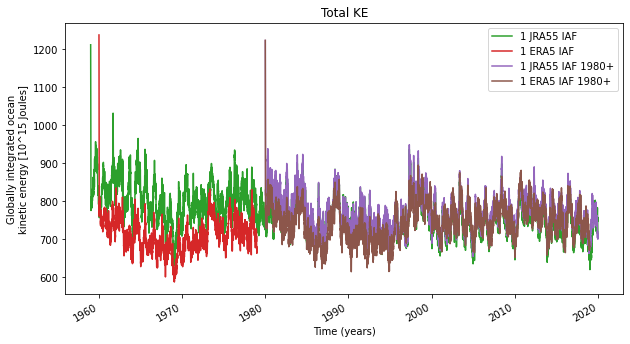

In [8]:
plot_timeseries('temp_global_ave')
plt.title('Global Average Temperature')
plot_timeseries('salt_global_ave')
plt.title('Global Average Salinity')
plot_timeseries('temp_surface_ave')
plt.title('Global Average SST')
plot_timeseries('salt_surface_ave')
plt.title('Global Average SSS')
plot_timeseries('ke_tot')
plt.title('Total KE')

## Circulation Diagnostics

### Drake Passage Transport

1deg_jra55_iaf
1deg_era5_iaf
1deg_jra55_iaf_1980p
1deg_era5_iaf_1980p
CPU times: user 11.7 s, sys: 635 ms, total: 12.4 s
Wall time: 12.5 s


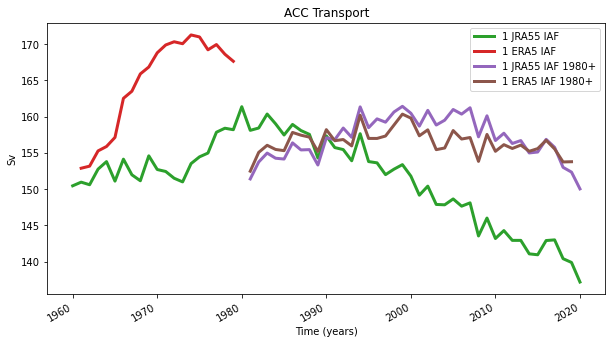

In [27]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
    #DP.plot(label=ekey,color=exptdict[ekey]['color'])
    DP.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.,label=ekey)
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.legend()

### AABW overturning circulation @ 55°S

1deg_jra55_iaf
1deg_era5_iaf
1deg_jra55_iaf_1980p
1deg_era5_iaf_1980p
CPU times: user 1min 57s, sys: 5.14 s, total: 2min 2s
Wall time: 2min 3s


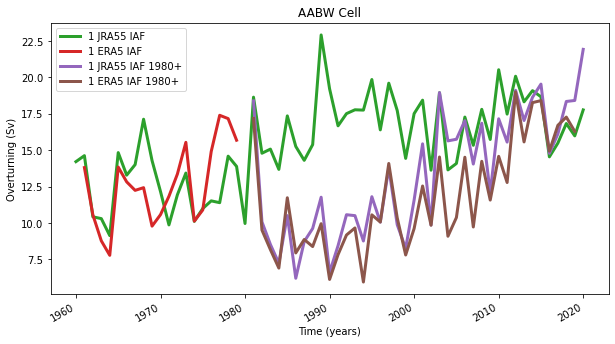

In [28]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    #psi_aabw_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_aabw_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.,label=ekey)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

## AABW overturning at 30S:

1deg_jra55_iaf
1deg_era5_iaf
1deg_jra55_iaf_1980p
1deg_era5_iaf_1980p
CPU times: user 2min 10s, sys: 8.85 s, total: 2min 19s
Wall time: 2min 21s


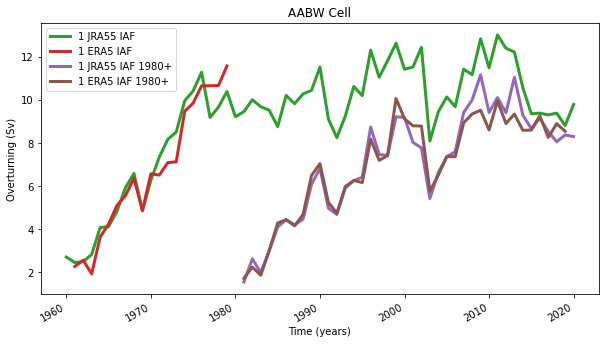

In [29]:
%%time
latitude=-30
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_aabw_gm = var2.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
    except:
        print('GM term not found')
    
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
    #psi_aabw_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_aabw_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.,label=ekey)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

### AMOC Overturning in density space @ 26°N

1deg_jra55_iaf
1deg_era5_iaf
1deg_jra55_iaf_1980p
1deg_era5_iaf_1980p
CPU times: user 1min 35s, sys: 5.49 s, total: 1min 41s
Wall time: 1min 42s


Text(0.5, 1.0, 'AMOC (rho) at 26N')

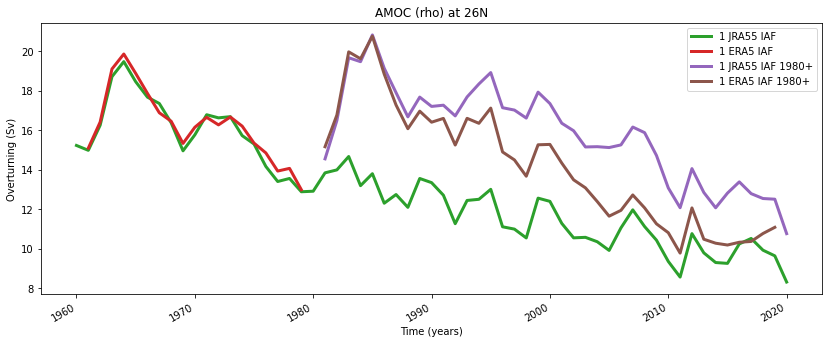

In [30]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    #psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.,label=ekey)

#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 26N')

## AMOC Overturning at 30S

1deg_jra55_iaf


2023-03-29 11:09:28,711 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_era5_iaf


2023-03-29 11:09:55,780 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 11:10:04,557 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1deg_jra55_iaf_1980p


2023-03-29 11:10:08,318 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-29 11:10:12,990 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-29 11:10:26,945 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_era5_iaf_1980p


2023-03-29 11:10:34,343 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:10:37,801 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


CPU times: user 1min 33s, sys: 4.81 s, total: 1min 37s
Wall time: 1min 37s


Text(0.5, 1.0, 'AMOC (rho) at 30S')

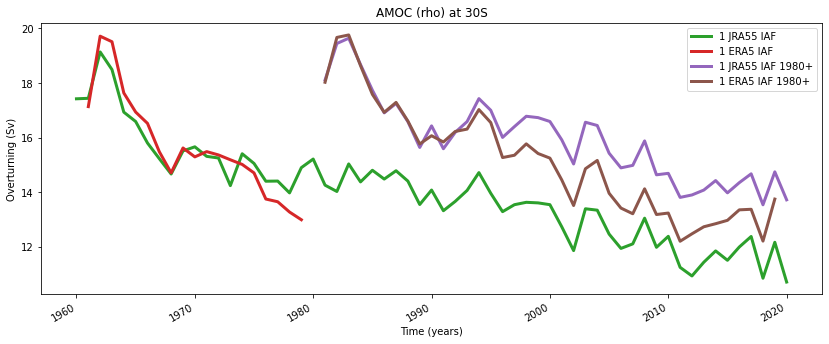

In [31]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-60,20.)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-30)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sel(grid_xt_ocean=slice(-60,20.)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-30)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
    #psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.,label=ekey)
    
#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 30S')

## NADW formation

2023-03-29 11:10:54,385 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf


2023-03-29 11:10:59,234 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:11:02,568 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:11:06,536 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:11:09,366 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1deg_era5_iaf


2023-03-29 11:11:43,783 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:11:47,247 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


1deg_jra55_iaf_1980p


2023-03-29 11:11:59,379 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:12:02,575 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:12:05,944 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:12:15,584 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


1deg_era5_iaf_1980p


2023-03-29 11:12:31,024 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-03-29 11:12:34,935 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 11:12:37,091 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


CPU times: user 1min 57s, sys: 5.38 s, total: 2min 3s
Wall time: 2min 3s


Text(0.5, 1.0, 'AMOC (rho) formation 40-70N')

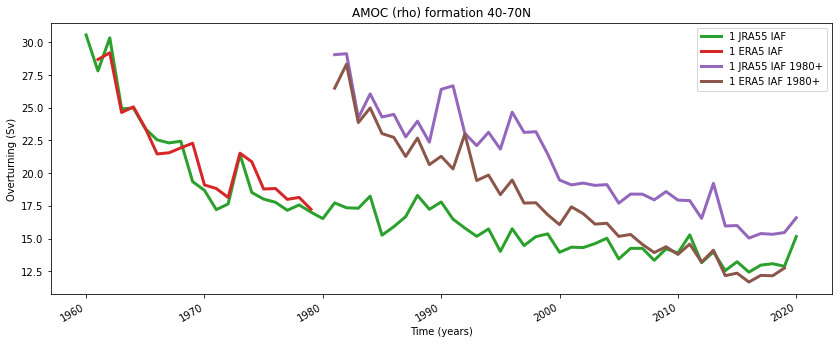

In [32]:
%%time
keys = exptdict.keys()
plt.figure(figsize=(14,5))
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = var.sum('grid_xt_ocean').sel(grid_yu_ocean=slice(50.,60.))*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_amoc_gm = var2.sum('grid_xt_ocean').sel(grid_yu_ocean=slice(50.,60.))*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').max('grid_yu_ocean')
    #psi_amoc_sum.plot(label=ekey,color=exptdict[ekey]['color'])
    psi_amoc_sum.resample(time='Y').mean().plot(color=exptdict[ekey]['color'],linewidth=3.,label=ekey)
    
#    psi_amoc_sum.plot(label=ekey)#,)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) formation 40-70N')

## SST bias to OISST:

In [5]:
times = ['2000-01-01','2019-01-01']
minyr=2000
maxyr=2019

In [6]:
# Observational SST:
files = []

for yr in np.arange(minyr,maxyr+1,1):
    files += sorted(glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc'))
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

OISST = OISST.rename({'lon':'xt_ocean','lat':'yt_ocean'})

In [10]:
keys = ['1 JRA55 IAF 1980+','1 ERA5 IAF 1980+']#exptdict.keys()
times = ['2000-01-01','2019-01-01']
sst = {}
sst_obs = (OISST.sst.sel(time=slice(times[0],times[1])).mean('time')).load()
i = 0
ekey = keys[0]
expt = exptdict[ekey]['expt']
sst[ekey] = (cc.querying.getvar(expt,'temp',session).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')-273.15).load()



#sst_int = sst[ekey].interp(xt_ocean=OISST.xt_ocean.values,yt_ocean=OISST.yt_ocean.values)

#sst_bias = sst_int - sst_obs
#sst_bias.plot(ax=axes[i][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
#axes[i][0].set_title(expt + ' - OISST 2000-2019 (degC)')

2023-03-29 11:49:42,575 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.47 GiB
2023-03-29 11:49:42,653 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.20 GiB -- Worker memory limit: 4.47 GiB
2023-03-29 11:49:42,758 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2023-03-29 11:49:54,790 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-03-29 11:49:54,789 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-03-29 11:49:54,790 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-03-29 11:49:54,789 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-03-29 11:49:54,789 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-03-29 11:49:54,789 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-03-29 11:49:54,790 - distributed.nanny - ERROR - Work

In [ ]:
keys = ['1 JRA55 IAF 1980+','1 ERA5 IAF 1980+']#exptdict.keys()
times = ['2000-01-01','2019-01-01']
fig, axes = plt.subplots(nrows=2,ncols=len(keys),figsize=(18,18))
sst = {}
for i, ekey in enumerate(keys):
    expt = exptdict[ekey]['expt']
    sst[ekey] = cc.querying.getvar(expt,'temp',session).isel(st_ocean=0).sel(time=slice(times[0],times[1])).mean('time')-273.15
    
    sst_obs = OISST.sst.sel(time=slice(times[0],times[1])).mean('time')
    
    sst_int = sst[ekey].interp(xt_ocean=OISST.xt_ocean.values,yt_ocean=OISST.yt_ocean.values)
    
    sst_bias = sst_int - sst_obs
    sst_bias.plot(ax=axes[i][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
    axes[i][0].set_title(expt + ' - OISST 2000-2019 (degC)')
    
(sst['1 ERA5 IAF 1980+']-sst['1 JRA55 IAF 1980+']).plot(ax=axes[i+1][0],vmin=-2.,vmax=2.,cmap='RdBu_r')
axes[i+1][0].set_title('ERA-5 - JRA-55 SST (degC)')

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2023-03-29 11:46:44,726 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2023-03-29 11:46:44,737 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/asyncio/runners.py", line 52, in run
    loop.close()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/async

Error in callback <function flush_figures at 0x154e23dbc4c0> (for post_execute):


    class Reader(object):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/yaml/reader.py", line 137, in Reader
    NON_PRINTABLE = re.compile('[^\x09\x0A\x0D\x20-\x7E\x85\xA0-\uD7FF\uE000-\uFFFD\U00010000-\U0010ffff]')
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/re.py", line 252, in compile
    return _compile(pattern, flags)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/re.py", line 304, in _compile
    p = sre_compile.compile(pattern, flags)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/sre_compile.py", line 792, in compile
    code = _code(p, flags)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/sre_compile.py", line 631, in _code
    _compile(code, p.data, flags)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/sre_compile.py", line 136, in _compile
    charset, hascased = _optimize_

### Ice Area (in both hemispheres)

1deg_jra55_iaf
1deg_era5_iaf
1deg_jra55_iaf_1980p
1deg_era5_iaf_1980p


2023-03-29 10:26:51,827 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:26:57,060 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:27:08,925 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Text(0.5, 1.0, 'Southern Ocean')

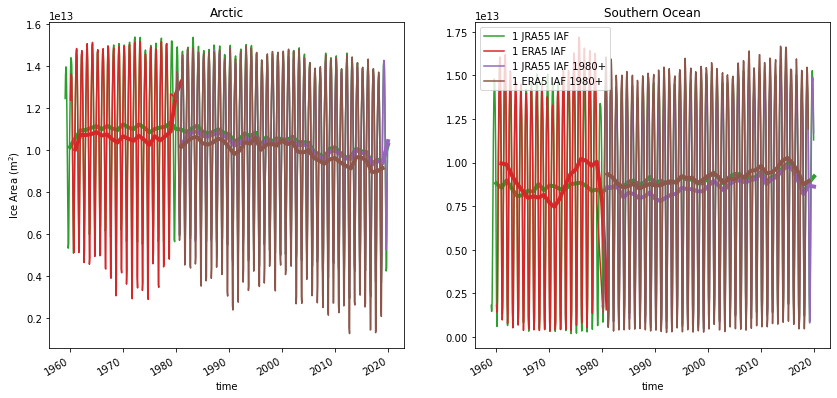

In [16]:
variable='aice_m'
fig,axes = plt.subplots(1,2,figsize=(14,6))
keys = exptdict.keys()
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    
    
    NH_area.isel(time=slice(0,-1)).plot(ax=axes[0],label=ekey,color=exptdict[ekey]['color'])
    SH_area.isel(time=slice(0,-1)).plot(ax=axes[1],label=ekey,color=exptdict[ekey]['color']) 
    NH_area.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=axes[0],color=exptdict[ekey]['color'],linewidth=4.)
    SH_area.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=axes[1],color=exptdict[ekey]['color'],linewidth=4.)
    
axes[0].set_ylabel(' Ice Area (m$^2$)')
axes[1].legend()
axes[0].set_title('Arctic')
axes[1].set_title('Southern Ocean')

1deg_jra55_iaf


2023-03-29 10:27:35,446 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:27:41,215 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:27:54,472 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:28:05,711 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:28:29,934 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:28:34,561 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:28:47,439 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:29:13,071 - distributed.utils_perf - WARNING - full garbage collections took

1deg_era5_iaf


2023-03-29 10:30:26,490 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:30:33,598 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:30:45,057 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:30:55,325 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:31:09,284 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_jra55_iaf_1980p


2023-03-29 10:31:32,880 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:31:48,018 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:31:54,886 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:31:57,272 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:32:12,528 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:32:17,433 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:32:34,261 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:32:40,339 - distributed.utils_perf - WARNING - full garbage collections took

1deg_era5_iaf_1980p


2023-03-29 10:33:07,289 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:33:12,847 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:33:18,357 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 10:33:37,577 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-03-29 10:33:43,219 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:34:00,953 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:34:06,419 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:34:22,270 - distributed.utils_perf - WARNING - full garbage collections took

Text(0.5, 1.0, 'Southern Ocean')

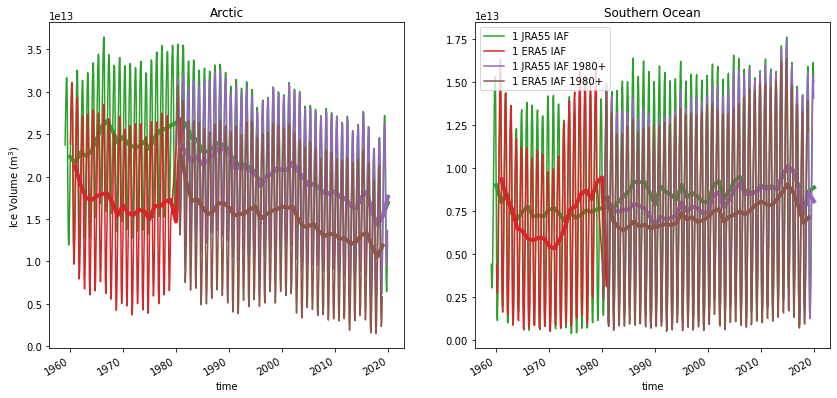

In [17]:
variable='vicen_m'
fig,ax = plt.subplots(1,2,figsize=(14,6))
keys = exptdict.keys()
for ekey in keys:
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    NH_vol.isel(time=slice(0,-1)).plot(ax=ax[0],label=ekey,color=exptdict[ekey]['color'])
    NH_vol.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=ax[0],color=exptdict[ekey]['color'],linewidth=4.)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    SH_vol.isel(time=slice(0,-1)).plot(ax=ax[1],label=ekey,color=exptdict[ekey]['color'])
    SH_vol.isel(time=slice(0,-1)).resample(time='Y').mean().plot(ax=ax[1],color=exptdict[ekey]['color'],linewidth=4.)
 
ax[0].set_ylabel('Ice Volume (m$^3$)')
ax[1].legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

## Global Overturning Streamfunction (density)

In [18]:
def plot_psi(psi_avg, clev=np.arange(-25,25,1.)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1032))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

1deg_jra55_iaf


2023-03-29 10:34:48,599 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:34:52,590 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:34:55,359 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:34:59,954 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:35:02,983 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:35:08,018 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:35:11,619 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:35:13,920 - distributed.utils_perf - WARNING - full garbage collections took

1deg_era5_iaf
1deg_jra55_iaf_1980p


2023-03-29 10:37:33,252 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_era5_iaf_1980p


2023-03-29 10:38:16,328 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:38:20,701 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:38:24,181 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:38:30,726 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:38:33,565 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:38:37,749 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


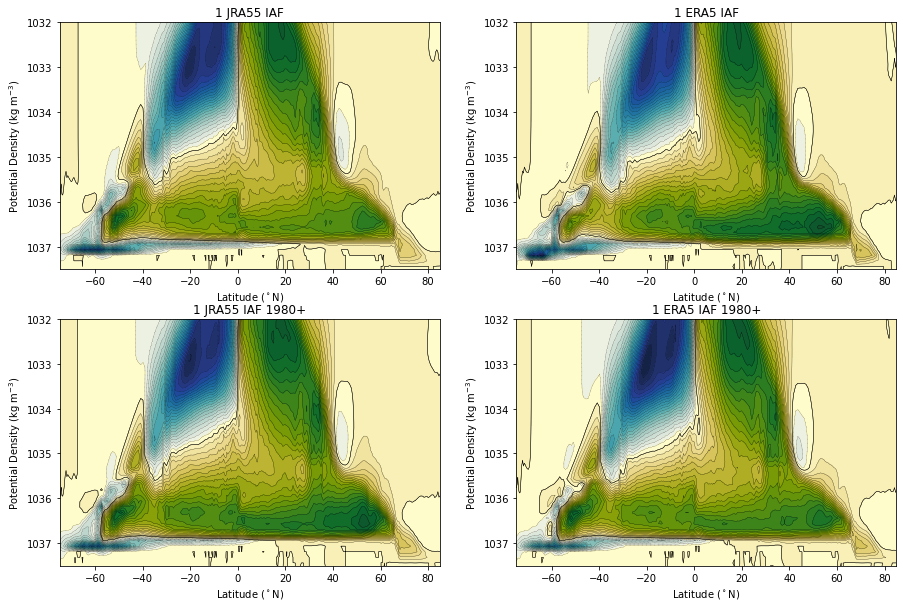

In [19]:
plt.figure(figsize=(15,10))
ii=0
keys = exptdict.keys()
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi = var.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

2023-03-29 10:39:26,427 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


1deg_jra55_iaf


2023-03-29 10:39:31,456 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:39:34,557 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:39:39,721 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:39:42,529 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-03-29 10:39:50,950 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:39:54,908 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:39:57,815 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:40:44,841 - distributed.utils_perf - WARNING - full garbage collections took

1deg_era5_iaf


2023-03-29 10:41:22,008 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-03-29 10:41:25,507 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_jra55_iaf_1980p


2023-03-29 10:42:18,526 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


1deg_era5_iaf_1980p


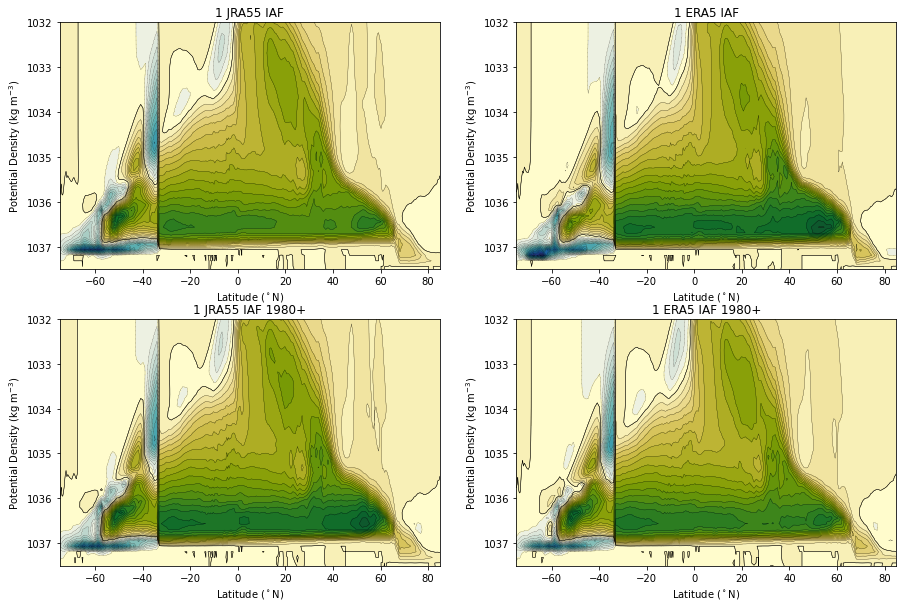

In [20]:
# Atlantic mask:
plt.figure(figsize=(15,10))
ii=0
keys = exptdict.keys()
for ekey in keys:
    ii+=1
    plt.subplot(2,2,ii)
    expt = exptdict[ekey]['expt']
    print(expt)
    
    # Atlantic mask:
    ht = cc.querying.getvar(expt,'ht',session,n=-1)
    land_mask = ~ht.isnull()
    
    ## create masks out of the above chunks
    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

    var = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi = var
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    psi = (psi*atlantic_sector_mask).sum('grid_xt_ocean').mean('time')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm',session)
        psi_gm = var2.mean('time').sum('grid_xt_ocean')*1.0e-9
        psi_avg = psi_avg + psi_gm
    except:
        print('GM term not found')
        
    psi_avg.load()
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

# OLD STUFF BELOW

## Area-Averaged Tracer Diagnostics

In [ ]:
def plot_depthintv(variable,zlims,end_time='2200-01-01',keys=exptdict.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,end_time=end_time)
        area = cc.querying.getvar(expt,'area_t',session,n=1)
        dzt = cc.querying.getvar(expt,'dzt',session,n=1).isel(time=0)
        vol = (dzt*area).sel(st_ocean = slice(zlims[0],zlims[1]))
        var = var.sel(st_ocean = slice(zlims[0],zlims[1]))
        varmean = ((var*vol).sum('st_ocean').sum('yt_ocean').sum('xt_ocean')/(vol.sum('st_ocean').sum('yt_ocean').sum('xt_ocean')))
        (varmean-273.15).plot(label=ekey)
    plt.legend()
    plt.title(str(zlims[0]) + ' - ' + str(zlims[1]) + 'm ' + variable)

### Upper 700m temp

In [ ]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[0.,700.],keys=keys)

### Upper 2000m temp

In [ ]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[0.,2000.],keys=keys)

### 2000m-bottom temp

In [ ]:
%%time
keys = exptdict.keys()
plot_depthintv('temp',[2000.,10000.],keys=keys)